# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
# !unzip processed_celeba_small.zip

In [2]:
# To keep running on the workspace beyond the 30mins standard wakeup
import signal

from contextlib import contextmanager

import requests


DELAY = INTERVAL = 4 * 60  # interval time in seconds
MIN_DELAY = MIN_INTERVAL = 2 * 60
KEEPALIVE_URL = "https://nebula.udacity.com/api/v1/remote/keep-alive"
TOKEN_URL = "http://metadata.google.internal/computeMetadata/v1/instance/attributes/keep_alive_token"
TOKEN_HEADERS = {"Metadata-Flavor":"Google"}


def _request_handler(headers):
    def _handler(signum, frame):
        requests.request("POST", KEEPALIVE_URL, headers=headers)
    return _handler


@contextmanager
def active_session(delay=DELAY, interval=INTERVAL):
    """
    Example:

    from workspace_utils import active session

    with active_session():
        # do long-running work here
    """
    token = requests.request("GET", TOKEN_URL, headers=TOKEN_HEADERS).text
    headers = {'Authorization': "STAR " + token}
    delay = max(delay, MIN_DELAY)
    interval = max(interval, MIN_INTERVAL)
    original_handler = signal.getsignal(signal.SIGALRM)
    try:
        signal.signal(signal.SIGALRM, _request_handler(headers))
        signal.setitimer(signal.ITIMER_REAL, delay, interval)
        yield
    finally:
        signal.signal(signal.SIGALRM, original_handler)
        signal.setitimer(signal.ITIMER_REAL, 0)


def keep_awake(iterable, delay=DELAY, interval=INTERVAL):
    """
    Example:

    from workspace_utils import keep_awake

    for i in keep_awake(range(5)):
        # do iteration with lots of work here
    """
    with active_session(delay, interval): yield from iterable

In [1]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [2]:
# necessary imports
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms

In [5]:
import os
def checkpoint(name_file, G, D, g_optimizer, d_optimizer, hyper, loss, checkpoint_dir='checkpoints_dcgan'):
    """Saves the parameters of both generators G and D.
        """
    
    batch_size, d_dim, g_dim, lr, beta1, beta2 = hyper
    
    try:
        os.mkdir(checkpoint_dir)
    except FileExistsError:
        
        model_path = os.path.join(checkpoint_dir, 'model_'+name_file+'.pkl')
        torch.save({
            'G_state_dict': G.state_dict(),
            'D_state_dict': D.state_dict(),
            'optimizer_G_state_dict': g_optimizer.state_dict(),
            'optimizer_D_state_dict': d_optimizer.state_dict(),
            'loss': loss,
            'batch_size': batch_size,
            'g_conv_dim': g_dim,
            'd_conv_dim': d_dim,
            'lr': lr,
            'beta1': beta1,
            'beta2': beta2
            }, model_path)
    
def load_checkpoint(name_file, checkpoint_dir='checkpoints_dcgan'):
    """Load the parameters of both generators G and D at a specific iteration
        """
#     checkpoint = torch.load(checkpoint_dir)
    model_path = os.path.join(checkpoint_dir, name_file)
    
    
    
    
    train_on_gpu = torch.cuda.is_available()
    
    if not train_on_gpu:
        device = torch.device('cpu')
        checkpoint = torch.load(model_path, map_location='cpu')
        print(device)
    else:
        device = torch.device('cuda')
        checkpoint = torch.load(model_path)
        
    
    
    
    G.load_state_dict(checkpoint['G_state_dict'])
    D.load_state_dict(checkpoint['D_state_dict'])
    g_optimizer.load_state_dict(checkpoint['optimizer_G_state_dict'])
    d_optimizer.load_state_dict(checkpoint['optimizer_D_state_dict'])
                              
    loss = checkpoint['loss']
                                  
    hyper = (checkpoint['batch_size'], checkpoint['g_conv_dim'], checkpoint['d_conv_dim'], checkpoint['lr'], checkpoint['beta1'], checkpoint['beta2'])
    
    return G, D, g_optimizer, d_optimizer, hyper, loss

In [6]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    # create transform pipeline by resizing the input image to a squared (image_size, image_size)
    # then from nuupy to pytorch tensor format
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor()])
    # apply transform pipeline to files for root and use ImageFolder method to create a full training dataset
    train_data = datasets.ImageFolder(root=data_dir, transform=transform)
    # create a Dataloader from training dtataset with predefined batch_sized and batches shuffle on
    train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    
    return train_data_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [7]:
# Define function hyperparameters
batch_size = 128
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

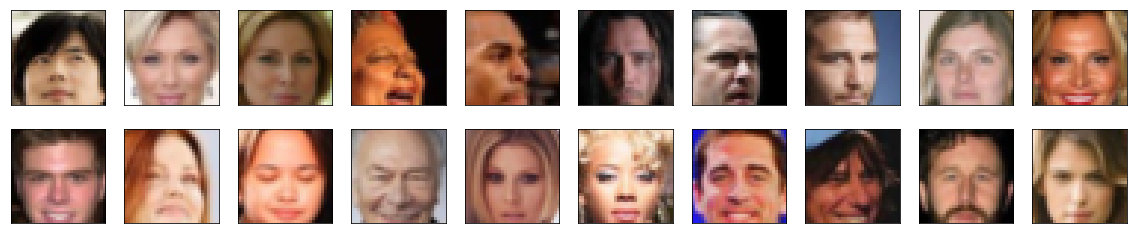

In [8]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [9]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    
    x_min, x_max = feature_range
    scaled = x * (x_max - x_min) + x_min
    
    return scaled


In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-1.)
Max:  tensor(0.9608)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [11]:
import torch.nn as nn
import torch.nn.functional as F

In [12]:
def conv(in_channel, out_channel, kernel_size, stride=2, padding=1, batch_norm=True):
    """
    Helper to buikd the convolutional layer: with Conv2D and 
    Batch Normalisation when needed (using 'batch_norm' switch)
    """
    layers = []
    
    # create convolutional layer
    conv_layer = nn.Conv2d(in_channel, out_channel, kernel_size, stride, padding, bias=False )
    
    # append to a list of this layer block
    layers.append(conv_layer)
    
    # add batch normalisation if needed
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channel))
        
    # return the convolutional by using the Sequential utility that combines the two possible layers 
    return nn.Sequential(*layers)
    

In [13]:

## Discriminator with 3 conv layers
class Discriminator(nn.Module):
    """
    class for the Discriminator part of the DCGAN
    """

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        
        # assign the convolutional dimension 'conv_dim' to self variable
        self.conv_dim = conv_dim

        # complete init function
        # create the network of three convolutional layers that transforms an input image with dimesion 32 x 32 x 3
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # to 16 x 16 x conv_dim without batch normalisation
        self.conv2 = conv(conv_dim, conv_dim*2, 4) # to 8 x 8 x conv_dim*2
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4) # to 4 x 4 x conv_dim*4
        
        # last fully connected layer
        self.fc1 = nn.Linear(conv_dim*4*4*4, 1) # and finally, from 4 x 4 x conv_dim*4 to 1x2048
        
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """

        # define feedforward behavior
        # the inpiut x passes through a series of three convolutional layers
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        
        # flatten input
        out = out.view(-1, self.conv_dim*4*4*4)
        
        # here the out form the convolutional layers will passes through the fully cvonnected layer
        # that converts to just 1 value
        out = self.fc1(out)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)


Tests Passed


~~~
## Discriminator with 4 conv layers 
class Discriminator(nn.Module):
    """
    class for the Discriminator part of the DCGAN
    """

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        
        # assign the convolutional dimension 'conv_dim' to self variable
        self.conv_dim = conv_dim

        # complete init function
        # create the network of three convolutional layers that transforms an input image with dimesion 32 x 32 x 3
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # to 16 x 16 x conv_dim without batch normalisation
        self.conv2 = conv(conv_dim, conv_dim*2, 4) # to 8 x 8 x conv_dim*2
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4) # to 4 x 4 x conv_dim*4
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        
        # last fully connected layer
        self.fc1 = nn.Linear(conv_dim*4*4*2, 1) # and finally, from 4 x 4 x conv_dim*4 to 1x2048
        
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """

        # define feedforward behavior
        # the inpiut x passes through a series of three convolutional layers
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = F.leaky_relu(self.conv4(out), 0.2)
        
        # flatten input
        out = out.view(-1, self.conv_dim*4*4*2)
        
        # here the out form the convolutional layers will passes through the fully cvonnected layer
        # that converts to just 1 value
        out = self.fc1(out)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)
~~~

## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [14]:
def deconv(in_channel, out_channel, kernel_size, stride=2, padding=1, batch_norm=True):
    """
    Helper to buid the Transpose Convolutional Layer: with ConvTranspose2D and 
    Batch Normalisation when needed (using 'batch_norm' switch)
    """
    layers = []
    
    #  create transpose convolutional layer
    deconv_layer = nn.ConvTranspose2d(in_channel, out_channel, kernel_size, stride, padding, bias=False)
    
    # append to a list of this layer block
    layers.append(deconv_layer)
    
    # add batch normalisation if needed
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channel))
        
    # return the transpose convolutional by using the Sequential utility that combines the two possible layers
    return nn.Sequential(*layers)

In [15]:

## Generator with 3 transconv layers
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        
        self.conv_dim = conv_dim

        # complete init function
        self.fc1 = nn.Linear(z_size, conv_dim*4 *4 *4)
        
        self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4, batch_norm=False)
        self.deconv2 = deconv(conv_dim*2, conv_dim, 4)
        
        self.deconv3 = deconv(conv_dim, 3, 4)
        
        
        
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        out = self.fc1(x)
        out = out.view(-1, self.conv_dim*4, 4, 4)
        
        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv2(out))
        
        out = F.tanh(self.deconv3(out))
        
        
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)


Tests Passed


~~~
## Generator with 4 transconv layers
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        
        self.conv_dim = conv_dim

        # complete init function
        self.fc1 = nn.Linear(z_size, conv_dim*4*4*2)
        
        self.deconv1 = deconv(conv_dim*8, conv_dim*4, 4, batch_norm=False)
        self.deconv2 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv3 = deconv(conv_dim*2, conv_dim, 4)
        
        self.deconv4 = deconv(conv_dim, 3, 4)
        
        
        
        
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        out = self.fc1(x)
        out = out.view(-1, self.conv_dim*8, 2, 2)
        
        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv2(out))
        
        out = F.relu(self.deconv3(out))
        
        out = F.tanh(self.deconv4(out))
        
        
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)
~~~

## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [16]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    # Taking into account the method adopted in the CycleGAN repository:
    # 1) check if the model class has attribute 'weight' and if it is a Conv2d or a Linear model
    
    if hasattr(m, 'weight') and (classname.find('Conv2d') != -1 or classname.find('Linear') != -1):
        # so, normalise the weights with a normal distribution centred in 0 and deviation 0.02
        nn.init.normal_(m.weight.data, 0.00, 0.02)
        
    # in the case of Batch normalisation
    elif classname.find('BatchNorm2d') != -1:
        
        # normalise the weights with a normal distribution centred in 1 and deviation 0.02
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        # bisa not on, so the bias is set to a constant=0
        nn.init.constant_(m.bias.data, 0.0)
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [18]:
# Define model hyperparams
# start with smallconvolutional dimensions(number of kernels)
d_conv_dim = 64
g_conv_dim = 64
# same as the value suggested in the DCGAN article
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Linear(in_features=4096, out_features=1, bias=True)
)

Generator(
  (fc1): Linear(in_features=100, out_features=4096, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [20]:
def real_loss(D_out, lmse=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    # determine the batch size from the figures batch
    batch_size = D_out.size(0)
    
    # smoothing the labels
    #create a set of labels equal to '1' smoothed by 0.9
    labels = torch.ones(batch_size)*0.9
    
    # move labels to GPU if enabled
    if train_on_gpu:
        labels = labels.cuda()
    
    # decide if to use least mean square or BCE logit loss
    # by default it uses BCE logit loss
    if lmse:
        return torch.mean((D_out.squeeze() - labels)**2)
    else:
        criterion = nn.BCEWithLogitsLoss()
        # squeeze the output to have same format for D_out and labels
        return criterion(D_out.squeeze(), labels)

def fake_loss(D_out, lmse=False):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    
    # same as 'real_loss' but for fake images the are compared to '0' values
    batch_size = D_out.size(0)
    
    if lmse:
        return torch.mean(D_out.squeeze()**2)
    else:
        labels = torch.zeros(batch_size)
        if train_on_gpu:
            labels = labels.cuda()
        criterion = nn.BCEWithLogitsLoss()
        return criterion(D_out.squeeze(), labels)

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [21]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G

# learning rate as suggested in the DCGAN paper
lr = 0.0002
# beta parameters as suggested in the DCGAN paper
beta1 = 0.5
beta2 = 0.999 # default

d_optimizer = optim.Adam(D.parameters(), lr, [beta1,beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1,beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [22]:
import time

# comment the next line and uncomment the next after that for the original function without extra added features support
def train(D, G, n_epochs, iteration, conv_deep=3, print_every=50):
# def train(D, G, n_epochs, print_every=50):

    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()
    

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
        
    tic = time.perf_counter()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)
            
            # generates name for the file storing generator images and model state
            # geberates also a tuple from the hyperparams
            # comment the next 4 lines to restore the original function
            if batch_i == 0:
                part_name_file = str(batch_size) + '_' + str(d_conv_dim) + '_' + str(lr) + '_' + \
                    str(beta1) + '_' + str(conv_deep)
                hyper = (batch_size, d_conv_dim, g_conv_dim, lr, beta1, beta2)
                
            
            
            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # zeroing the gradient for the discriminator optimiser
            d_optimizer.zero_grad()
            
            # 1. Train the discriminator on real and fake images
            # move real images to GPU if enabled
            if train_on_gpu:
                real_images = real_images.cuda()
                
            # calculate the likeliness that the image is recognised real by the discriminator
            real_out = D(real_images)
            
            # calculate the real loss by using the helper function previously created
            d_real_loss = real_loss(real_out)
            
            # generate a random uniform array between(-1, 1) for z to be compared to tanh results
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            # transform numpy array in torch tensor
            z = torch.from_numpy(z).float()
            
            # move z tensor to GPU if enabled 
            if train_on_gpu:
                z = z.cuda()
                
            # generate fake  image by using the generator
            fake_images = G(z)
            
            # feed the fake image to the generator
            fake_out = D(fake_images)
            
            # calculate the loss for the fake image
            d_fake_loss = fake_loss(fake_out)
            
            # obtain the total discriminator loss by summing real and fake parts
            d_loss = d_real_loss + d_fake_loss
            
            # backward step to calculate gradient
            d_loss.backward()
            d_optimizer.step()
            

            
            # zeroing the gradient for the generator optimiser
            g_optimizer.zero_grad()
            
            # 2. Train the generator with an adversarial loss
            # generate a random uniform array between(-1, 1) for z to be compared to tanh results
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            # transform numpy array in torch tensor
            z = torch.from_numpy(z).float()
            # move z tensor to GPU if enabled
            if train_on_gpu:
                z = z.cuda()
                
            # generate fake  image by using the generator
            fake_images = G(z)
            
            # feed the fake image to the discriminator
            fake_out = D(fake_images)
            
            # try to fool the discriminator to let it believe that it is a real image
            g_loss = real_loss(fake_out)
            
            # backword step to update gradients
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}-{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(batch_i,
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))
        


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode
        
        # uncomment these lines, if you want to save your model
        checkpoint_every=10
        # Save the model parameters
        name_file = f"train_samples_{iteration+epoch+1}_{part_name_file}"
        if epoch % checkpoint_every == 0:
            checkpoint(name_file, G, D, g_optimizer, d_optimizer, hyper, losses)
    
    # save state of the network at the end of the training
    checkpoint(name_file, G, D, g_optimizer, d_optimizer, hyper, losses)
    # Save training generator samples
    name_file = name_file + '.pkl'
    with open(name_file, 'wb') as f:
        pkl.dump(samples, f)
        
    # timing
    toc = time.perf_counter()
    passed_time = toc - tic
    print(f"epoch: {epoch} in {passed_time:0.4f} seconds ({passed_time/60.:0.4f} mins)")
    
    
    # finally return losses
    return losses, passed_time

In [23]:
## helpers for loading/creating dictionary to store hyperparams and losses in json files
def load_losses_data(id_string1, hyper, n_epochs, conv_deep=3):
    """
    Helper to create a dictionary with the losses and hyperparam of the training run
    params: hyper ==> tuple with the hyperparams values
            conv_deep: number of conv/transconv layers in the model (default: 3)
            n_epoch: number of actual epochs in the run
            id_string1: hyperparams stringified for file or id purposes
    """
    
    start_epoch = 0
    
    dict_found = False

    ## search for a file where we save losses and params
    try:
        ## if found it creates a list of dictionaries from file entries
        with open('DCGAN_losses.json', 'r') as f:
            dcgan_losses = json.load(f)
            print("'DCGAN_losses.json' file found!!")
            print("Load saved loasses and hyperparams")
            print()
            
    except FileNotFoundError:
        ## if not found it create an emapy list
        dcgan_losses = []
        print("'DCGAN_losses.json' is not there!!")
        print("Create loasses and hyperparams dict from sratch")
        print()

    # print(f"saved dcgan so far: {dcgan_losses}")


    if dcgan_losses == []:
        # if the list is empty it inits the prams part of the dictionary with the actula hyperparams
        print("Init dictionary")
        print()
        json_dict = {
            'id': id_string1,
            'n_epochs': n_epochs,
            'n_batches': hyper[0],
            'conv_dim': hyper[1],
            'z_size': hyper[2],
            'learning_rate': hyper[3],
            'beta1': hyper[4],
            'beta2': hyper[5],
            'conv_deep': conv_deep
        }
    else:
        # if the list is not empty
        print("Search if dictionary with same hyperparams are already saved")
        print()
        for data in dcgan_losses:
            # it searches if a run with the same id has been already performed 
            # (it assumes that if it founds the entry the next run will be a restart)
            if data['id'] == id_string1:
                print("Found dictionary with run hyperparams")
                print()
                json_dict = data
                
                # format of 'id_loss' has single (separeting intervals) and double underscore (separeting restarts)
                id_loss_temp = data['losses_d_g']['id_loss'].split("_")
                
                # search if there is a null character and remove it
                id_loss = [wrd for wrd in id_loss_temp if wrd != '']

                # take the last number as start epochs for the next restart
                start_epoch=int(id_loss[-1])
                
                dict_found = True
                
        if not dict_found:
            # if not found this means that even though the file exists
            # the actual run has not been performed before
            print("Init dictionary with run hyperparams from scratch")
            print()
#                 end_epoch = start_epoch
            json_dict = {
                'id': id_string1,
                'n_epochs': n_epochs,
                'n_batches': hyper[0],
                'conv_dim': hyper[1],
                'z_size': hyper[2],
                'learning_rate': hyper[3],
                'beta1': hyper[4],
                'beta2': hyper[5],
                'conv_deep': conv_deep
            }
    
    # return the full list of the entries found in the file: 'dcgan_losses'
    # the dictionary for the actual run ready to be filled with the new losses
    # the start eopch (if the run is a restart the 'start_epoch' is updated
    return dcgan_losses, json_dict, start_epoch


def save_losses_data(id_string2, json_dict, dcgan_losses, n_epochs):
    """
    Helper to save the new losses to a new or updated entry
    params: id_string2 string to be add to the entry as id for the losses to track the possible restarts
            json_dict: dictionary of entries coming from the previous loading/creation of the params/losses
            dcgan_losses: is the list of entries to be dupmped to the file at the end of the actual run
            n_epochs; numer of total epochs for the actual run
    """
    if 'losses_d_g' in json_dict.keys():
        print("Previous losses found!")
        print()

    #     print(json_dict)

        old_n_epochs = json_dict['n_epochs']
        json_dict['n_epochs'] = old_n_epochs + n_epochs


        time_string = json_dict['losses_d_g']['timing_s']
        time_string = time_string + "__" + str(time)


        json_dict['losses_d_g']['timing_s'] = time_string
        id_string3 = json_dict['losses_d_g']['id_loss']
        id_string3 = id_string3 + "__" + id_string2
        json_dict['losses_d_g']['id_loss'] = id_string3


        json_dict['losses_d_g']['values'].extend(losses)

#         print(json_dict)

#         input("continue?: press return")

        for index, list_dict in enumerate(dcgan_losses):

#             print(f"Is it here?: {list_dict} at index: {index}")
            if list_dict['id'] == id_string1:
                
                print(f"Found datat id in the file, at index {index}")
                print("I modify the data at that index with the update ones")
#                 input('I am in the right place?: press return')
                dcgan_losses[index] = json_dict
    else:

    #     print(json_dict)
        print("Create losses entry!")
        print()
        json_dict['losses_d_g'] = {}
        json_dict['losses_d_g']['timing_s'] = str(time)
        json_dict['losses_d_g']['id_loss'] = id_string2
        json_dict['losses_d_g']['values'] = losses
        dcgan_losses.append(json_dict)


    # dcgan_losses.append(json_dict)

    with open('DCGAN_losses.json', 'w+') as f:
        json.dump(dcgan_losses, f, indent = 1)

Set your number of training epochs and train your GAN!

In [25]:
import json

import os

n_epochs = 30

# few lines controlling loading of the model for restart/test runs

restart_run = True

if restart_run:
    name_file='model_train_samples_35_128_64_0.0002_0.5_3.pkl'
    G, D, g_optimizer_param, d_optimizer_param, hyper, loss = load_checkpoint(name_file, checkpoint_dir='checkpoints_dcgan')
    assert hyper[0] == batch_size, f"data retrieved {hyper(0)} and batch_size {batch_size} differ"
    print("Model state loaded")
    input ('Is it ok to continue?')
    print()
    print(G)
    print(D)
    
#########
    
start_epoch=0

### set a swoitch for the number of conv/transconv layers in the model
conv_deep = 3

## create a string from the hyperparams
id_string1 = f"{batch_size}_{img_size}_{d_conv_dim}_{z_size}_{lr}_{beta1}_{beta2}_{conv_deep}"

print(id_string1)

### create a tuple of the hypeparams to be shared

hyper = (batch_size, d_conv_dim, z_size, lr, beta1, beta2)

### prepare the datat in dictionary to be stored at the end of the run
### calls 'load_losses_data' function

dcgan_losses, json_dict, start_epoch = load_losses_data(id_string1, hyper, n_epochs, conv_deep=conv_deep)

## here we train
with active_session():
    losses, time = train(D, G, n_epochs=n_epochs, iteration=start_epoch, conv_deep=conv_deep, print_every=15)

### further string to be created with the stra and end number of epochs done in the run
id_string2 = f"{start_epoch}_{start_epoch+n_epochs}"

### save to file the data such as dict of hyperparams and losses
### calls 'save_losses_data' function
save_losses_data(id_string2, json_dict, dcgan_losses, n_epochs)

It is ok?
Generator(
  (fc1): Linear(in_features=100, out_features=4096, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv3): Sequential(
    (0): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

128_32_32_100_0.0002_0.5_0.999_3
128_32_64_100_0.0002_0.5_0.999_3
128_32_64_100_0.0002_0.5_0.999_4


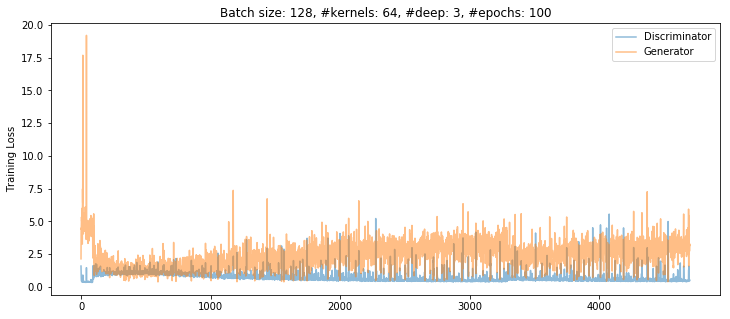

In [10]:
import json
with open('DCGAN_losses.json', 'r') as f:
    dcgan_losses = json.load(f)
losses = []
for loss in dcgan_losses:
    print(loss['id'])
    if loss['learning_rate'] == 0.0002 and loss['n_batches'] == 128:
        losses.append(np.array(loss['losses_d_g']['values']))
#         print(loss["n_batches"])

        
fig, ax1= plt.subplots(1, 1, figsize=(12, 5), sharey=True)
    
ax1.plot(losses[1].T[0], label='Discriminator', alpha=0.5)
ax1.plot(losses[1].T[1], label='Generator', alpha=0.5)
ax1.set_title("Batch size: 128, #kernels: 64, #deep: 3, #epochs: 100")
ax1.set_ylabel('Training Loss')
ax1.legend()



## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [4]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples, filename):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))
    plt.savefig(filename, bbox_inches='tight')
    plt.show

In [7]:
with open('train_samples_100_128_64_0.0002_0.5_3.pkl', 'rb') as f:
    samples1 = pkl.load(f)

### After 5 epoch

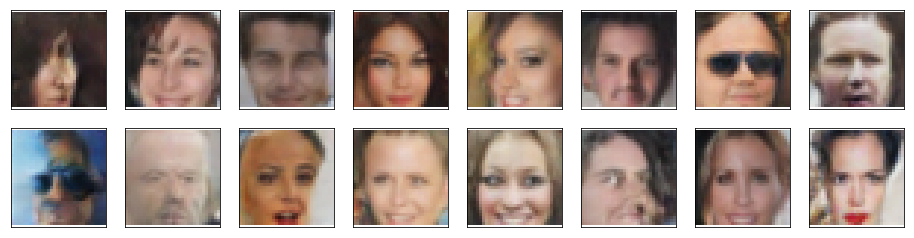

In [8]:
_ = view_samples(5, samples1, 'train_samples_5_128_64_0.0002_0.5_3.png')

### after 100 epochs

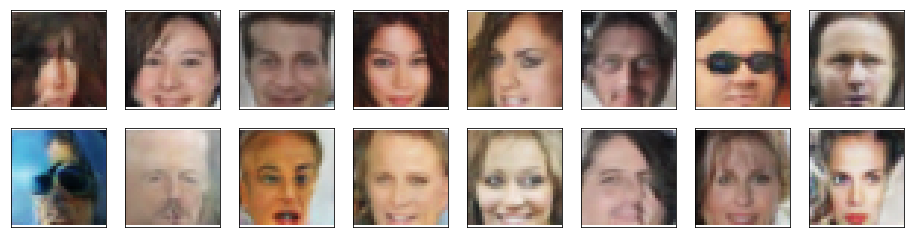

In [9]:
_ = view_samples(-1, samples1, 'train_samples_100_128_64_0.0002_0.5_3.png')

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result

**Answer:** 

* **Dataset bias**: from the following source https://www.kaggle.com/jessicali9530/celeba-dataset I have found that the most suitable attributes for a bias review are: Sex, Age, Physical Shape and Race
  - **Sex**: it seems that the dataset has got less males (~41%) than females
  - **Age**: ~77% of the subjects is classified as young
  - **Physical shape**: WHO reported that in the 2016 ~39% of the adult population was overweight, and overall the 13% of the adult population was considered obese. So, with only a representative of ~5% the dataset obviously does not reflect the world average. This is to be expected since this is a celebrity dataset.
  - **Race**: not mentioned among the attributes, and therefore a possible hidden source of bias. This is a bias recurrent in almost any dataset. Unfortunately, this is diffult to get rid of. Even though in the last years the social networks have to some extent leveled up the celebrities' nationality and allowed local famous people to be known more widely abroad, it is still common behaviour to associate them to western countries and in particular much more to white than to other ethnic origins.
  

* **Model hyperparameters and size**

I started with testing the following hyperparameters:

- batch size: **32, 64, 128**
- image_size: **32x32x3**
- z_size: **100** (fixed everywhere)
- D and G starting dimension of conv/transconv layers (number of initial kernels): **32**
- D and G network number of layers: **3**
- learning rate: **0.001**
- Adam optimizer (fixed everywhere)
- beta1: **0.9** (default)
- beta2: **0.999** (default)

In the following figure it is clear that with the previous hyperparams after 15 epochs (collecting training D and G loss **47** times per epoch) the model shows 1) slow convergency at higher batch size, 2) the Generator loss has large oscillations and spikes without correspondence to Discriminator spikes (learning peaks), 3) the Discriminator does not show slow decrease with increasing number epochs.

![](32_64_128_32_001.png)

By changing as suggested in the original DCGAN paper:
- learning rate: **0.0002**
- beta1: **0.5**

the model shows a better learning evolution (next figure) with batch size 128 better than 64 and 32: 

![](32_64_128_32_0002.png)


So, I chose batch size: **128** and I tested against convolution dimension: **32** and **64** (deep neural network **3 and 4** layers) number of epochs: **35**

![](35_128_32_64_32_3_0002.png)

I took **64** has a strating number of kernels (convolution dimension), dispite the spikes with 3 conv layers and and large oscillation for 4 conv layers. Because of the long simulation time for a deeper neural convolutional network (4) of more than 2 hours for 35 epochs, I decided for a shallower network (3) indeed much faster (~40 mins for the same of expoch) and given almost the same performance.

Please compare the following examples of the generated faces at the end of the **35** epochs for:

### A **3**-layer network:

![](train_samples_35_128_64_0.0002_0.5_3.png)

### A **4**-layer network:

![](train_samples_35_128_64_0.0002_0.5_4.png)

Finally, the chosen hyperparams are:

- batch size: **128**
- image_size: **32x32x3**
- z_size: **100** (fixed everywhere)
- D and G starting dimension of conv/transconv layers (number of intial kernels): **64**
- D and G network number of layers: **3**
- learning rate: **0.0002**
- Adam optimizer (fixed everywhere)
- beta1: **0.5** (default)
- beta2: **0.999** (default)
- number of epochs: **100**

For the figures please refer above sections: **Training loss** and **Generator samples from training**


### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.